Get into correct directory

In [1]:
!ls

drive  sample_data


In [2]:
%cd drive/MyDrive/CS273B Final Project

/content/drive/MyDrive/CS273B Final Project


In [3]:
!ls

'Attention U-Net Version 2.ipynb'
 dataset
 dataset-20240603T151808Z-001.zip
'dataset U-NET'
 Kaggle_Attention_UNET_Implementation.ipynb
 stage1_solution_combined_masks-20240603T144926Z-001.zip
 stage1_test_data-20240603T145431Z-001.zip
 U-NET_Implementation_Version_2.h5
'U-Net-Implementation Version 2.ipynb'


In [4]:
# for data load
import os

# for reading and processing images
import imageio
from PIL import Image

# for visualizations
import matplotlib.pyplot as plt

import numpy as np # for using np arrays

# for bulding and running deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

Loading in dataset

In [5]:
def LoadData (path1, path2):
    """
    Looks for relevant filenames in the shared path
    Returns 2 lists for original and masked files respectively

    """
    # Read the images folder like a list
    image_dataset = os.listdir(path1)
    mask_dataset = os.listdir(path2)

    # Make a list for images and masks filenames
    orig_img = []
    mask_img = []
    for file in image_dataset:
        orig_img.append(file)
    for file in mask_dataset:
        mask_img.append(file)

    # Sort the lists to get both of them in same order (the dataset has exactly the same name for images and corresponding masks)
    orig_img.sort()
    mask_img.sort()

    return orig_img, mask_img

Preprocessing Data

In [6]:
def PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2):
    """
    Processes the images and mask present in the shared list and path
    Returns a NumPy dataset with images as 3-D arrays of desired size
    Please note the masks in this dataset have only one channel
    """
    # Pull the relevant dimensions for image and mask
    m = len(img)                     # number of images
    i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image
    m_h,m_w,m_c = target_shape_mask  # pull height, width, and channels of mask

    # Define X and Y as number of images along with shape of one image
    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)

    # Resize images and masks
    count = 0
    total_num_of_masks_and_images = len(img)
    for file in img:
        index = img.index(file)

        # convert image into an array of desired shape (3 channels)


        path = os.path.join(path1, file)
        single_img = Image.open(path).convert('RGB')
        single_img = single_img.resize((i_h,i_w))
        single_img = np.reshape(single_img,(i_h,i_w,i_c))
        single_img = single_img/255.
        X[index] = single_img

        # convert mask into an array of desired shape (1 channel)
        single_mask_ind = mask[index]
        path = os.path.join(path2, single_mask_ind)
        single_mask = Image.open(path).convert('L')
        # print(single_mask.size)

        single_mask = single_mask.resize((m_h, m_w))


        single_mask = np.array(single_mask)
        single_mask = np.where(single_mask > 128, 1, 0)
        # print(single_mask.size)
        # print("London")
        # print(single_mask)
        single_mask = np.reshape(single_mask,(m_h,m_w,m_c))
        # single_mask = single_mask - 1 # to ensure classes #s start from 0
        y[index] = single_mask

        count += 1
        if count % 10 == 0 or count == total_num_of_masks_and_images:
          print("Completed Resizing " + str(count) + "/" + str(total_num_of_masks_and_images))
    return X, y

Constructing the U-NET Architecture

U-NET Encoder Block

In [7]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning.
    Dropout can be added for regularization to prevent overfitting.
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow
    # Proper initialization prevents from the problem of exploding and vanishing gradients
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)

    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions
    skip_connection = conv

    return next_layer, skip_connection

U-NET Decoder Block

In [8]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)

    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters,
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

Compile U-NET Blocks

Num_classes might need to be set to 1 (you're only looking for the cell segmentation).

In [9]:
def UNetCompiled(input_size=(128, 128, 3), n_filters=32, n_classes=1):
    """
    Combine both encoder and decoder blocks according to the U-Net research paper
    Return the model as output
    """
    # Input size represent the size of 1 image (the size used for pre-processing)
    inputs = Input(input_size)

    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size.
    # Observe the number of channels will be equal to number of output classes
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same', activation='sigmoid')(conv9)

    # conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

Executing the functions above to train model

Load in the data

In [10]:
!ls

'Attention U-Net Version 2.ipynb'
 dataset
 dataset-20240603T151808Z-001.zip
'dataset U-NET'
 Kaggle_Attention_UNET_Implementation.ipynb
 stage1_solution_combined_masks-20240603T144926Z-001.zip
 stage1_test_data-20240603T145431Z-001.zip
 U-NET_Implementation_Version_2.h5
'U-Net-Implementation Version 2.ipynb'


In [11]:
""" Load Train Set and view some examples """
# Call the apt function
path1_images = "dataset/non-aug/train/images/"
path2_images = "dataset/non-aug/valid/images/"
path3_images = "dataset/non-aug/test/images/"

path1_masks = "dataset/non-aug/train/masks/"
path2_masks = "dataset/non-aug/valid/masks/"
path3_masks = "dataset/non-aug/test/masks/"


img, mask = LoadData(path1_images, path2_images, path3_images, path1_masks, path2_masks, path3_masks)

# View an example of image and corresponding mask
# the images and the masks have the same name and so they should be sorted
show_images = 1
for i in range(show_images):
    img_view  = imageio.imread(path1_images + img[i])
    mask_view = imageio.imread(path1_masks + mask[i])
    print(img_view.shape)
    print(mask_view.shape)
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(img_view)
    arr[0].set_title('Image '+ str(i))
    arr[1].imshow(mask_view)
    arr[1].set_title('Masked Image '+ str(i))

TypeError: LoadData() takes 2 positional arguments but 6 were given

In [12]:
!ls

'Attention U-Net Version 2.ipynb'
 dataset
 dataset-20240603T151808Z-001.zip
'dataset U-NET'
 Kaggle_Attention_UNET_Implementation.ipynb
 stage1_solution_combined_masks-20240603T144926Z-001.zip
 stage1_test_data-20240603T145431Z-001.zip
 U-NET_Implementation_Version_2.h5
'U-Net-Implementation Version 2.ipynb'


Placing Data from the three folders into one folder split into images and masks.

In [13]:
!ls

'Attention U-Net Version 2.ipynb'
 dataset
 dataset-20240603T151808Z-001.zip
'dataset U-NET'
 Kaggle_Attention_UNET_Implementation.ipynb
 stage1_solution_combined_masks-20240603T144926Z-001.zip
 stage1_test_data-20240603T145431Z-001.zip
 U-NET_Implementation_Version_2.h5
'U-Net-Implementation Version 2.ipynb'


In [ ]:
import shutil
import os

# Define the source and destination directories. Have to do this multiple times
# for the different directories of images.
train_images_dir = 'dataset/non-aug/train/images/'
validate_images_dir = 'dataset/non-aug/valid/images/'
test_images_dir = 'dataset/non-aug/test/images/'

train_mask_dir = 'dataset/non-aug/train/masks/'
validate_mask_dir = 'dataset/non-aug/valid/masks/'
test_mask_dir = 'dataset/non-aug/test/masks/'


image_destination_dir = 'dataset U-NET/images'
mask_destination_dir = 'dataset U-NET/masks'

# Create the destination directory if it does not exist
os.makedirs(image_destination_dir, exist_ok=True)
os.makedirs(mask_destination_dir, exist_ok=True)

# List all files in the source directory
image_files_train = os.listdir(train_images_dir)
image_files_validate = os.listdir(validate_images_dir)
image_files_test = os.listdir(test_images_dir)

mask_files_train = os.listdir(train_mask_dir)
mask_files_validate = os.listdir(validate_mask_dir)
mask_files_test = os.listdir(test_mask_dir)

print(len(image_files_train))
print(len(mask_files_train))
print(len(image_files_validate))
print(len(mask_files_validate))
print(len(image_files_test))
print(len(mask_files_test))

536
536
134
134
65
65


Moving the images to the new directory

In [ ]:
# Transfer over all of the images to the image directory
count = 0
total_num_files = len(image_files_train)
for file in image_files_train:
    if file.endswith('.png'):
        shutil.copy(os.path.join(train_images_dir, file), os.path.join(image_destination_dir, file))
        count += 1
        if count % 10 == 0 or count == total_num_files:
            print("Completed " + str(count) + "/" + str(total_num_files))

print("Finished transferring training images.")


count = 0
total_num_files = len(image_files_validate)
for file in image_files_validate:
    if file.endswith('.png'):
        shutil.copy(os.path.join(validate_images_dir, file), os.path.join(image_destination_dir, file))
        count += 1
        if count % 10 == 0 or count == total_num_files:
            print("Completed " + str(count) + "/" + str(total_num_files))

print("Finished transferring validation images.")

count = 0
total_num_files = len(image_files_test)
for file in image_files_test:
    if file.endswith('.png'):
        shutil.copy(os.path.join(test_images_dir, file), os.path.join(image_destination_dir, file))
        count += 1
        if count % 10 == 0 or count == total_num_files:
            print("Completed " + str(count) + "/" + str(total_num_files))

print("Finished transferring test images")


# Transfer over all the images to the mask directory
count = 0
total_num_files = len(mask_files_train)
for file in mask_files_train:
    if file.endswith('.png'):
        shutil.copy(os.path.join(train_mask_dir, file), os.path.join(mask_destination_dir, file))
        count += 1
        if count % 10 == 0 or count == total_num_files:
            print("Completed " + str(count) + "/" + str(total_num_files))

print("Finished transferring training masks")

count = 0
total_num_files = len(mask_files_validate)
for file in mask_files_validate:
    if file.endswith('.png'):
        shutil.copy(os.path.join(validate_mask_dir, file), os.path.join(mask_destination_dir, file))
        count += 1
        if count % 10 == 0 or count == total_num_files:
            print("Completed " + str(count) + "/" + str(total_num_files))

print("Finished transferring validation masks")

count = 0
total_num_files = len(mask_files_test)
for file in mask_files_test:
    if file.endswith('.png'):
        shutil.copy(os.path.join(test_mask_dir, file), os.path.join(mask_destination_dir, file))
        count += 1
        if count % 10 == 0 or count == total_num_files:
            print("Completed " + str(count) + "/" + str(total_num_files))

print("Finished transferring test masks")

print("All PNG images have been copied successfully.")

Completed 10/536
Completed 20/536
Completed 30/536
Completed 40/536
Completed 50/536
Completed 60/536
Completed 70/536
Completed 80/536
Completed 90/536
Completed 100/536
Completed 110/536
Completed 120/536
Completed 130/536
Completed 140/536
Completed 150/536
Completed 160/536
Completed 170/536
Completed 180/536
Completed 190/536
Completed 200/536
Completed 210/536
Completed 220/536
Completed 230/536
Completed 240/536
Completed 250/536
Completed 260/536
Completed 270/536
Completed 280/536
Completed 290/536
Completed 300/536
Completed 310/536
Completed 320/536
Completed 330/536
Completed 340/536
Completed 350/536
Completed 360/536
Completed 370/536
Completed 380/536
Completed 390/536
Completed 400/536
Completed 410/536
Completed 420/536
Completed 430/536
Completed 440/536
Completed 450/536
Completed 460/536
Completed 470/536
Completed 480/536
Completed 490/536
Completed 500/536
Completed 510/536
Completed 520/536
Completed 530/536
Completed 536/536
Finished transferring training images

Process Data:

<ipython-input-14-c69e02d2a124>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_view  = imageio.imread(image_path + img[i])
<ipython-input-14-c69e02d2a124>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask_view = imageio.imread(mask_path + mask[i])


(512, 512, 4)
(512, 512)


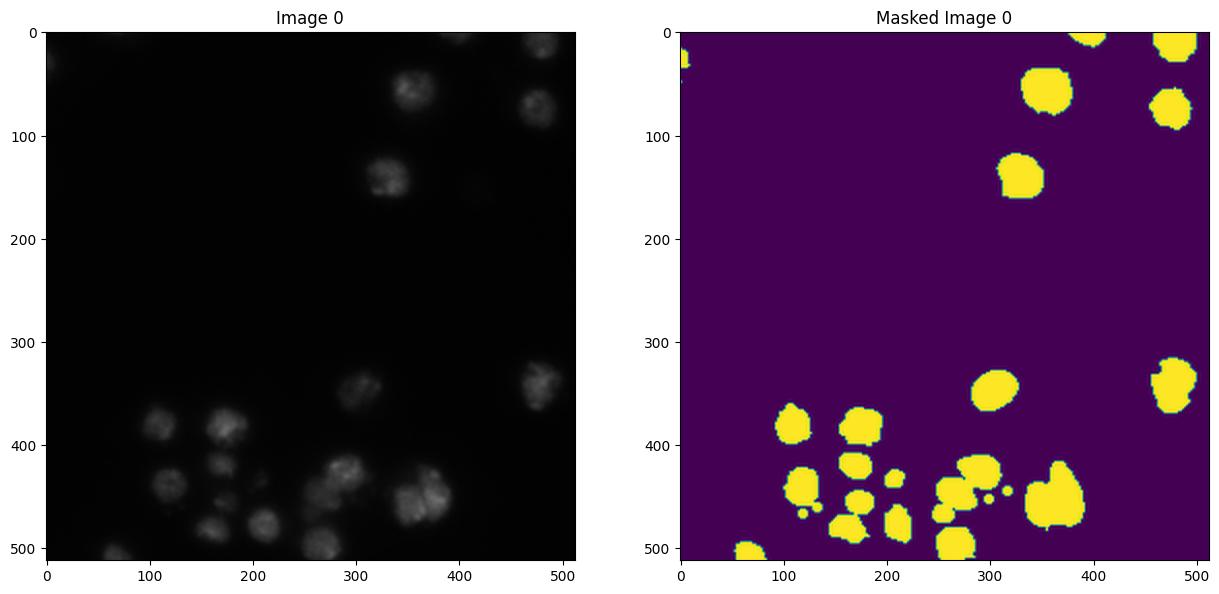

In [14]:
""" Load Train Set and view some examples """
# Call the apt function
image_path = "dataset U-NET/images/"
mask_path = "dataset U-NET/masks/"
img, mask = LoadData(image_path, mask_path)

# View an example of image and corresponding mask
show_images = 1
for i in range(show_images):
    img_view  = imageio.imread(image_path + img[i])
    mask_view = imageio.imread(mask_path + mask[i])
    print(img_view.shape)
    print(mask_view.shape)
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(img_view)
    arr[0].set_title('Image '+ str(i))
    arr[1].imshow(mask_view)
    arr[1].set_title('Masked Image '+ str(i))

Completed Resizing 10/735
Completed Resizing 20/735
Completed Resizing 30/735
Completed Resizing 40/735
Completed Resizing 50/735
Completed Resizing 60/735
Completed Resizing 70/735
Completed Resizing 80/735
Completed Resizing 90/735
Completed Resizing 100/735
Completed Resizing 110/735
Completed Resizing 120/735
Completed Resizing 130/735
Completed Resizing 140/735
Completed Resizing 150/735
Completed Resizing 160/735
Completed Resizing 170/735
Completed Resizing 180/735
Completed Resizing 190/735
Completed Resizing 200/735
Completed Resizing 210/735
Completed Resizing 220/735
Completed Resizing 230/735
Completed Resizing 240/735
Completed Resizing 250/735
Completed Resizing 260/735
Completed Resizing 270/735
Completed Resizing 280/735
Completed Resizing 290/735
Completed Resizing 300/735
Completed Resizing 310/735
Completed Resizing 320/735
Completed Resizing 330/735
Completed Resizing 340/735
Completed Resizing 350/735
Completed Resizing 360/735
Completed Resizing 370/735
Completed 

Text(0.5, 1.0, 'Processed Masked Image ')

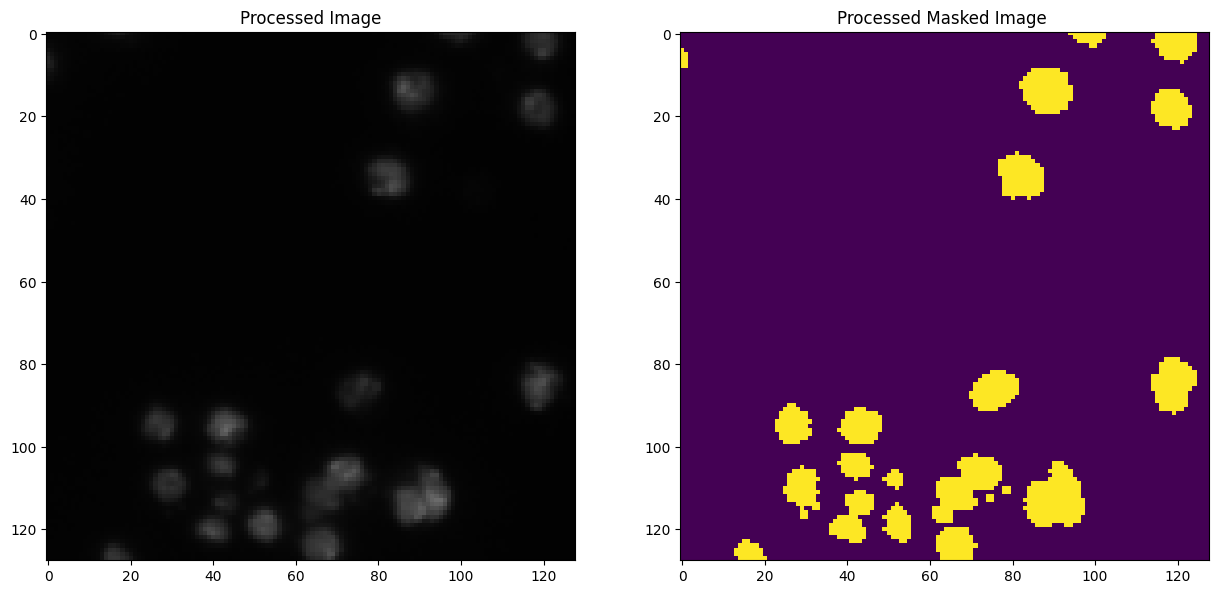

In [15]:
# Define the desired shape
target_shape_img = [128, 128, 3]
target_shape_mask = [128, 128, 1]

# Process data using apt helper function
X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, image_path, mask_path)

# QC the shape of output and classes in output dataset
print("X Shape:", X.shape)
print("Y shape:", y.shape)
# There are 3 classes : background, pet, outline
print(np.unique(y))

# Visualize the output
image_index = 0
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[image_index])
arr[0].set_title('Processed Image')
arr[1].imshow(y[image_index,:,:,0])
arr[1].set_title('Processed Masked Image ')

Split Train and Test Set

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)

In [16]:
from sklearn.model_selection import train_test_split

# First, split into train and temp sets (where temp is for further splitting into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=123)  # Adjust the size as needed

# Now, split the temp set into validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123)  # Splitting 50/50


Build U-NET Architecture

In [17]:
unet = UNetCompiled(input_size=(128,128,3), n_filters=32, n_classes=1)

In [18]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d_1[0][0]']            
 Normalization)                                                                               

Compile and run the model

In [19]:
unet.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
             metrics=['accuracy'])

In [20]:
results = unet.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
17/17 [==============================] - 33s 583ms/step - loss: 0.5977 - accuracy: 0.8116 - val_loss: 0.4284 - val_accuracy: 0.8814
Epoch 2/20
17/17 [==============================] - 4s 216ms/step - loss: 0.3305 - accuracy: 0.8542 - val_loss: 0.2271 - val_accuracy: 0.8825
Epoch 3/20
17/17 [==============================] - 4s 224ms/step - loss: 0.2267 - accuracy: 0.8805 - val_loss: 0.1660 - val_accuracy: 0.9230
Epoch 4/20
17/17 [==============================] - 4s 222ms/step - loss: 0.1663 - accuracy: 0.9270 - val_loss: 0.1678 - val_accuracy: 0.9302
Epoch 5/20
17/17 [==============================] - 4s 224ms/step - loss: 0.1347 - accuracy: 0.9469 - val_loss: 0.1214 - val_accuracy: 0.9506
Epoch 6/20
17/17 [==============================] - 4s 226ms/step - loss: 0.1145 - accuracy: 0.9547 - val_loss: 0.1438 - val_accuracy: 0.9434
Epoch 7/20
17/17 [==============================] - 4s 216ms/step - loss: 0.1145 - accuracy: 0.9540 - val_loss: 0.1156 - val_accuracy: 0.9573
Epoch

In [21]:
unet.save("U-NET_Implementation_Version_2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


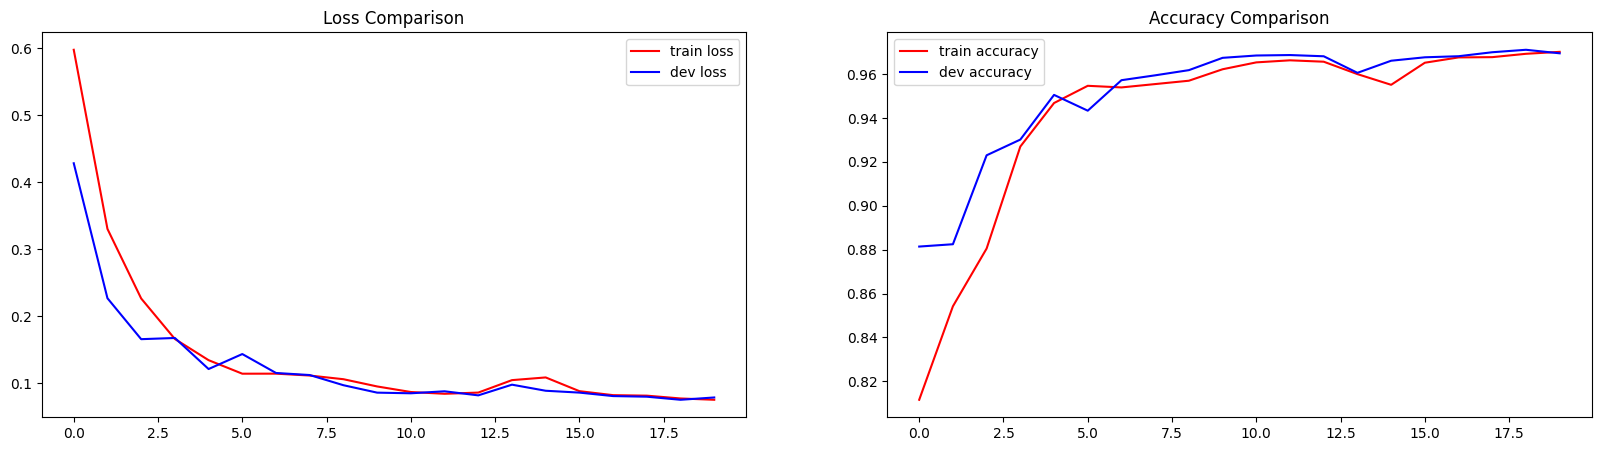

In [22]:
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'dev loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'dev accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()


In [23]:
unet.evaluate(X_test, y_test)

4/4 [==============================] - 2s 803ms/step - loss: 0.0733 - accuracy: 0.9710


[0.07325185835361481, 0.9710050225257874]

Visualize Mask

In [26]:
def VisualizeResults(index):
    img = X_test[index]
    img = img[np.newaxis, ...]  # Adding batch dimension
    pred_y = unet.predict(img)
    pred_mask = (pred_y > 0.5).astype(np.uint8)  # Convert probabilities to binary mask
    pred_mask = pred_mask[0, ..., 0]  # Adjust dimensions for visualization

    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(X_test[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y_test[index,:,:,0], cmap='gray')  # Ensure grayscale display
    arr[1].set_title('Actual Masked Image')
    arr[2].imshow(pred_mask, cmap='gray')  # Ensure grayscale display
    arr[2].set_title('Predicted Masked Image')


1/1 [==============================] - 0s 18ms/step


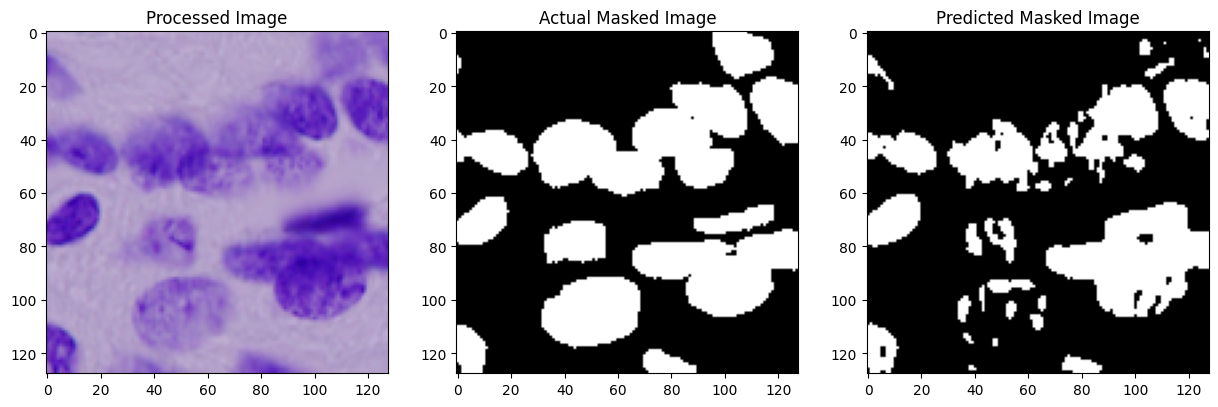

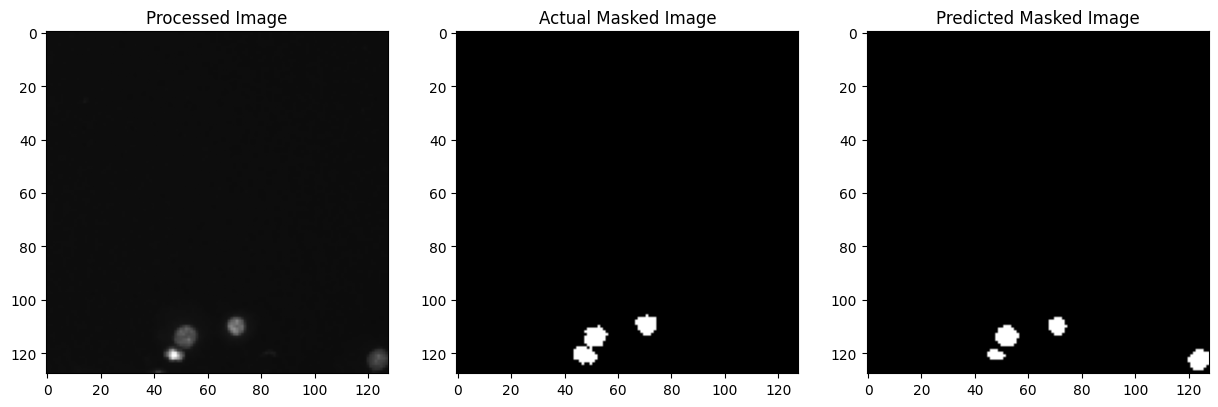

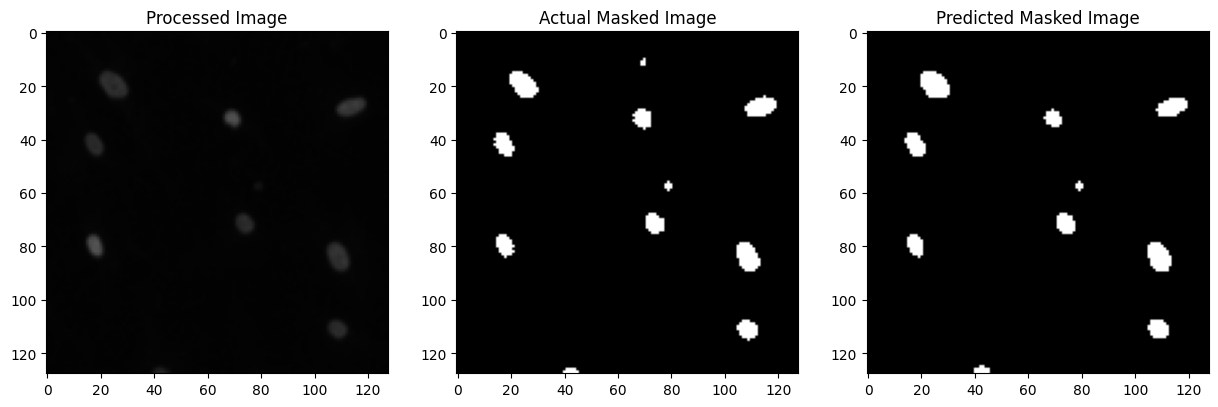

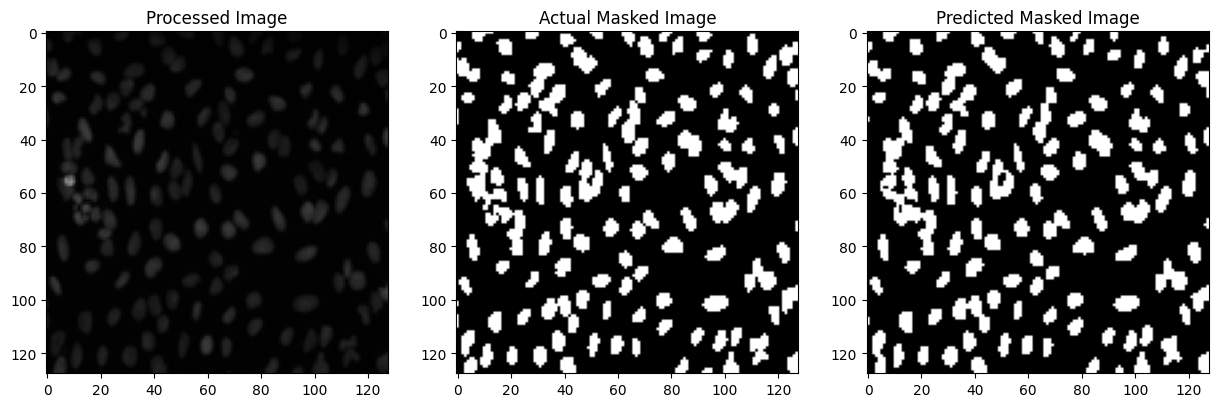

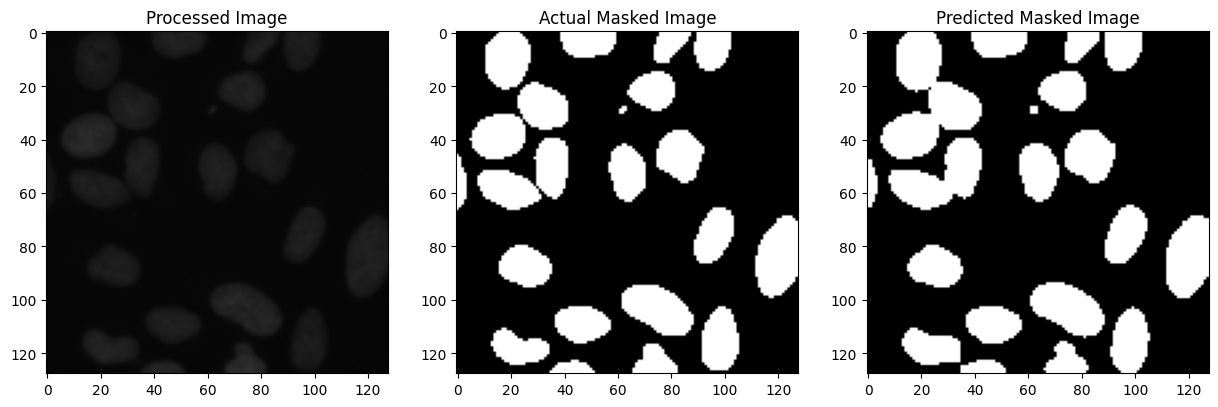

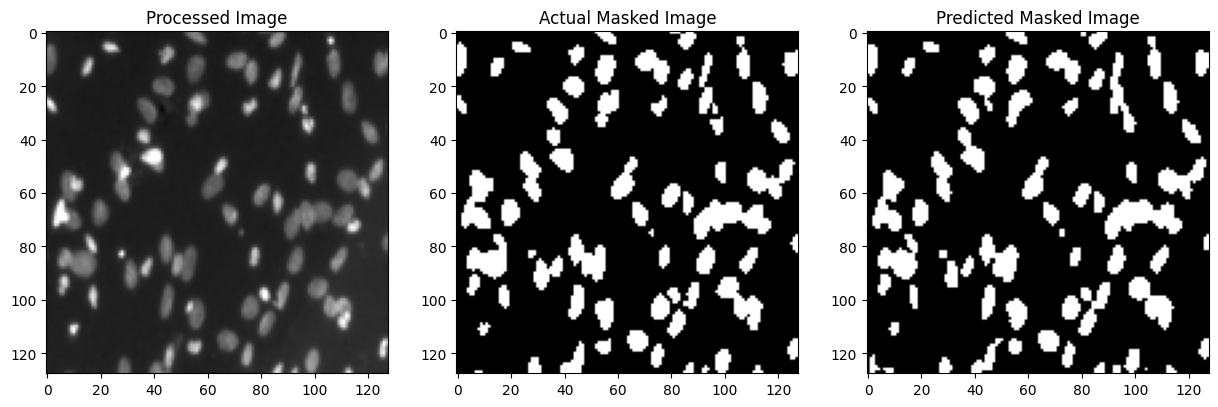

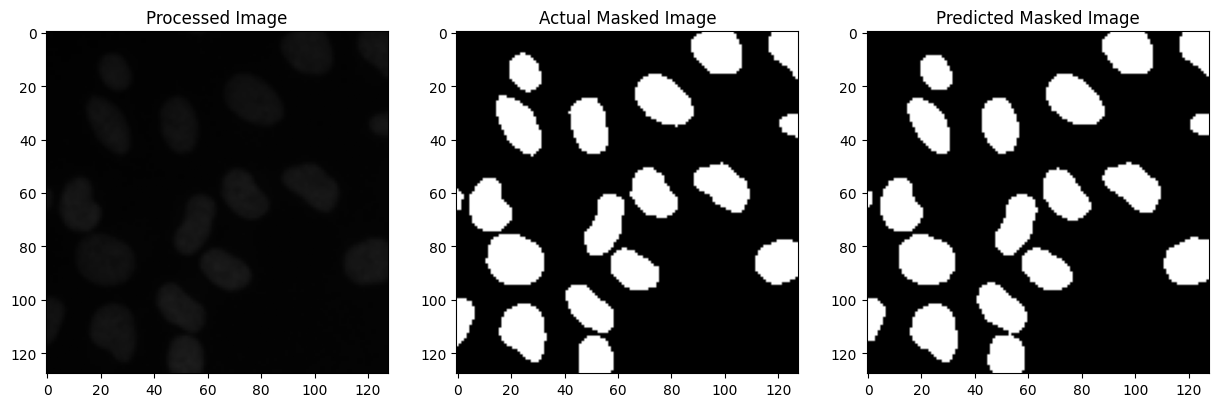

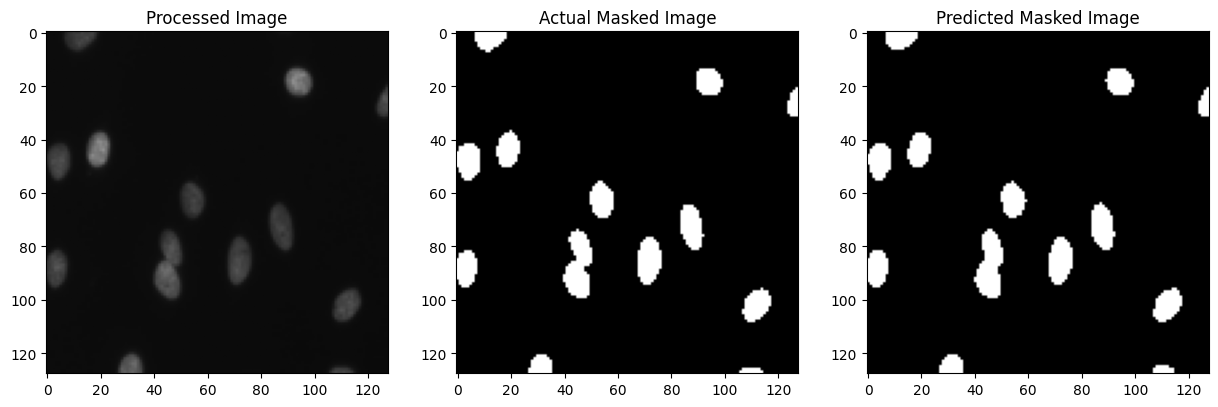

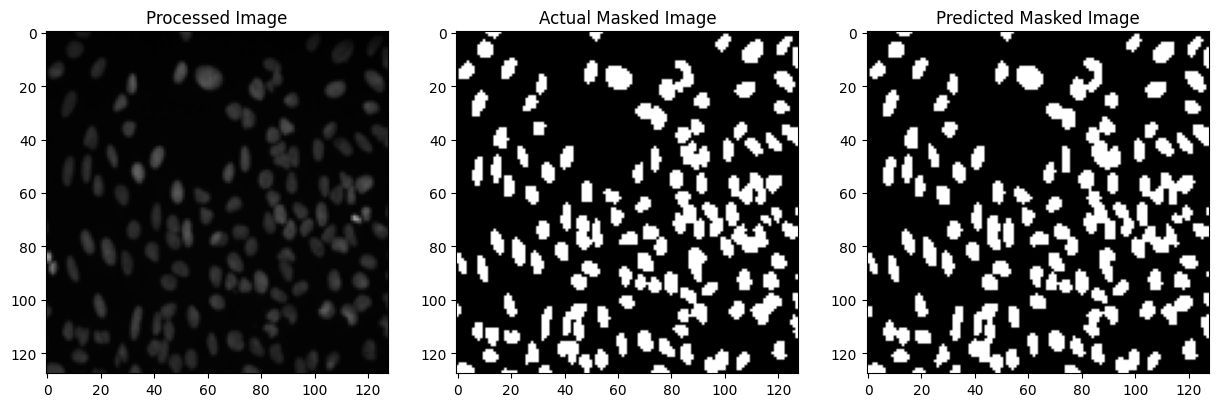

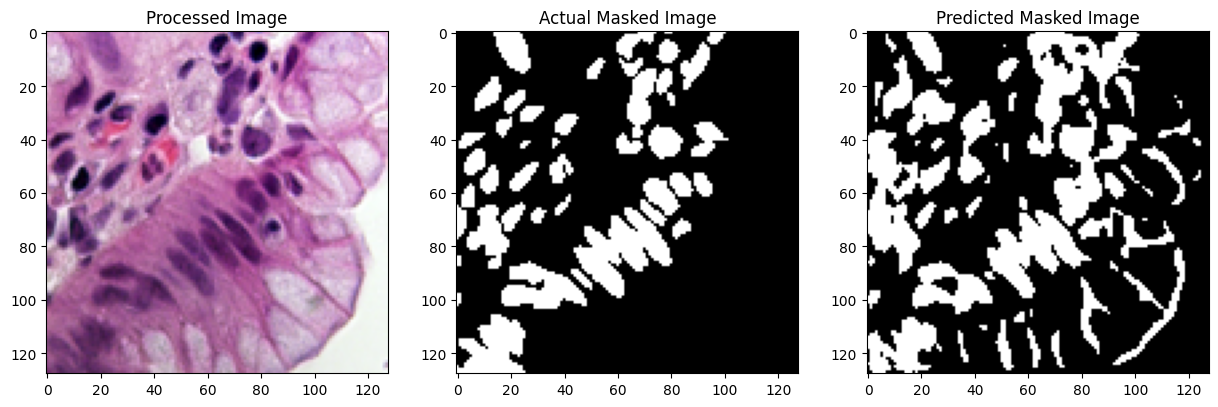

In [28]:
for i in range(10):
  VisualizeResults(i)